# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os
from scipy.misc import comb
import seaborn as sns
import firvtools as firv
import string


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()
dataDir = cwd+"/depo/Data/"
saveDir = cwd+"/depo/Outputs/"

Loaded!


We will be performing the analysis on swap curves in JPY, EUR, GBP, USD.

For now, let's focus on the EUR Swap Curve.

In [2]:
currencies = ["EUR", "GBP", "JPY", "USD"]
fwd = {}
par = {}

def loadCurrencies(ccylist):
    for ccy in currencies:
        fwd[ccy] = pd.read_pickle(dataDir+"fwd"+ccy)[::-1]
        temp = pd.read_pickle(dataDir+ccy)[::-1]
        if temp.columns.values[0][-1] != "y":
            temp.rename(columns=lambda x: str(x[3:])+"y", inplace=True)
        par[ccy] = temp
        print ("Loaded "+ccy)
    return

def matchTenors(c1, c2):
    assets = list(set(c1.columns.values) & set(c2.columns.values))
    assets.sort(key=lambda x: len(x.split("y")))
    assets.sort(key=lambda x: int(x.split("y")[0]))
    r1 = c1.copy()["assets"]
    r2 = c2.copy()["assets"]
    return r1, r2
    
loadCurrencies(currencies)

Loaded EUR
Loaded GBP
Loaded JPY
Loaded USD


We'll assume that we were doing this analysis in June 2015 so that we can do some OOS analysis later on.

,2y,5y,10y,20y,30y
Dates,,,,,
2015-12-08,-226.963242,-236.366958,-244.164071,-246.291331,-243.080933
2015-12-09,-228.673242,-237.446958,-243.734071,-244.421331,-240.750933
2015-12-10,-226.153242,-232.846958,-239.434071,-241.041331,-238.000933
2015-12-11,-232.873242,-242.816958,-247.964071,-249.011331,-245.700933
2015-12-14,-229.873242,-237.246958,-243.014071,-244.941331,-242.000933


,2y,5y,10y,20y,30y
Dates,,,,,
2016-12-02,-200.653242,-216.696958,-232.924071,-246.361331,-248.290933
2016-12-05,-197.803242,-213.806958,-231.404071,-245.341331,-247.450933
2016-12-06,-197.493242,-214.066958,-231.144071,-244.321331,-246.090933
2016-12-07,-199.673242,-218.426958,-236.584071,-249.861331,-251.800933
2016-12-08,-197.783242,-213.266958,-228.594071,-240.491331,-242.230933


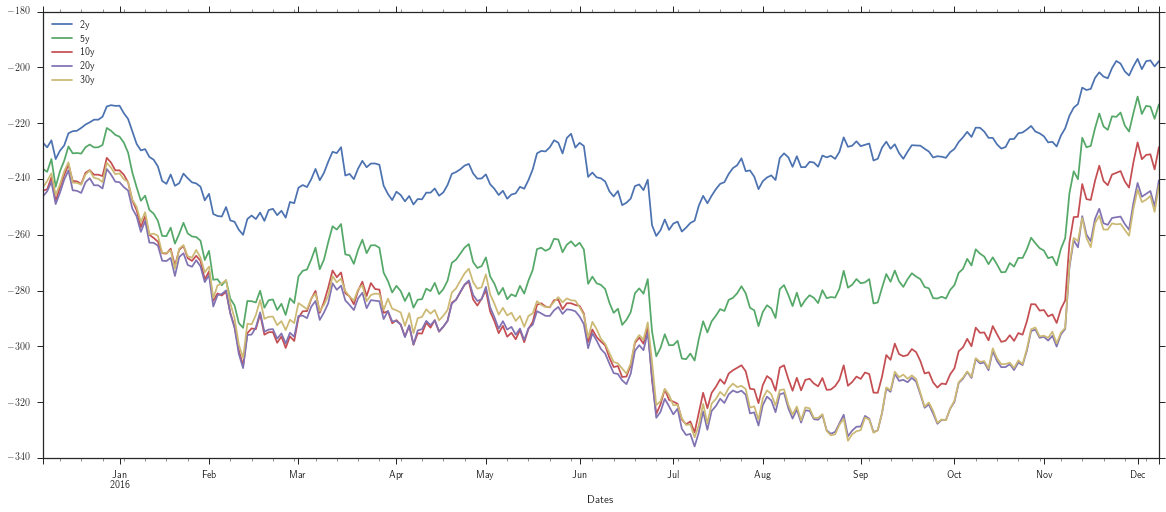

In [3]:

start = dt.datetime(2015, 12, 8)
end = dt.datetime(2016,12, 8)
tenors = ["2y", "5y", "10y", "20y", "30y"]
currency = "USD"
rawData = par[currency][tenors] * 100
rawData = rawData-rawData.mean()
assets = rawData.columns.values
data = rawData[start:end]
display(data.head())
sns.set_style("ticks")
rawplot = data.plot(figsize=(20,8))
display(rawData.dropna().tail())

firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

(Edit: The re-orientation function was written after the fact. Considerable time was spent on automating a way to re-orient the PCs post ante. However, given that yield curve dynamics are understood in that PC1 is level, PC2 slope and PC3 curvature, we can write a reorient function. The reorient function calculates correlations between the level, slope, fly and the individual PCs and re-orients the PCs as they should be. )

In [4]:
def kfacReconstruct(data, evTable, k=3, cols = [], auto= 0):
    ## Auto reorients EVs and PCs
    ## Pick securities to receive data for. If no input, do all. 
    if cols ==[]: 
        cols = data.columns.values
    
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)
    if auto != 0:
        reOrient = pcReorient(data, factorTS, tol=auto)[:totFactors]
        newEVs = evTable.copy()
        newFactors = factorTS.copy()
        for i in range(totFactors):
            newEVs.loc[:, evTable.columns[i]] *= reOrient[i]
            newFactors.loc[:, factorTS.columns[i]] *= reOrient[i]
        factorTS = newFactors
        evTable = newEVs

    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    reRaw = kRebuild + meanVals
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = reRaw[cols]
    result["residuals"] = kResiduals[cols]
    
    return result, evTable
    
def pcReorient(data, factors, tol=2):
    lenData = len(data.columns.values)
    numCurves = lenData//2
    numFlies = comb(lenData, 3)    
    
    pc1corr, pc2corr, pc3corr = 1, 1, 1
        
    if tol > numCurves or tol > numFlies:
        print ("Error.")
        return
    numFactors = len(factors.columns.values)
    if numFactors >=1:
        ## check pc1
        split = lenData//tol
        pc1check = pd.concat([data.ix[:,j*split] for j in range(tol)], axis=1)
        pc1corr = pc1check.corrwith(factors["PC1"]).mean()
    if numFactors >=2:
        ## check pc2
        pc2check = pd.concat([data.ix[:,-i]-data.ix[:,i] for i in range(numCurves)], axis=1)
        pc2corr = pc2check.corrwith(factors["PC2"]).mean()
    if numFactors >=3:
        ## check pc3
        pc3check = data.ix[:,numCurves]*2 - data.ix[:,0] - data.ix[:,-1]
        pc3corr = factors["PC3"].corr(pc3check).mean()
    
    
    return np.sign([pc1corr, pc2corr, pc3corr])

def staticPCA(data, n=3, freq=1, corrW = 12, autoOrient=2, plot=True):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM
    
    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])

    ## Reconstruct
    reConResult = kfacReconstruct(raw, evTable, n, auto=autoOrient)
    reconstructed = reConResult[0]
    evTable = reConResult[1].copy()
    evTable.index = covM.index
    results["evecs"] = evTable
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    
    return results




## Playing around with the PCA results

Let's load our GBP curve data into this function and see what we get.

In [5]:
print("Eigenvectors:")
pca1 = staticPCA(data, freq=1, n=1)
pca2 = staticPCA(data, freq=1, n=2)
pca3 = staticPCA(data, freq=1, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])

Eigenvectors:


,PC1,PC2,PC3
2y,0.174434,-0.726895,-0.590162
5y,0.410162,-0.475186,0.346659
10y,0.511352,-0.065816,0.548515
20y,0.521835,0.282177,-0.165963
30y,0.517249,0.402327,-0.450693


Eigenvalues:


[91.797463453214675, 7.9935678392934415, 0.17827509487989307]

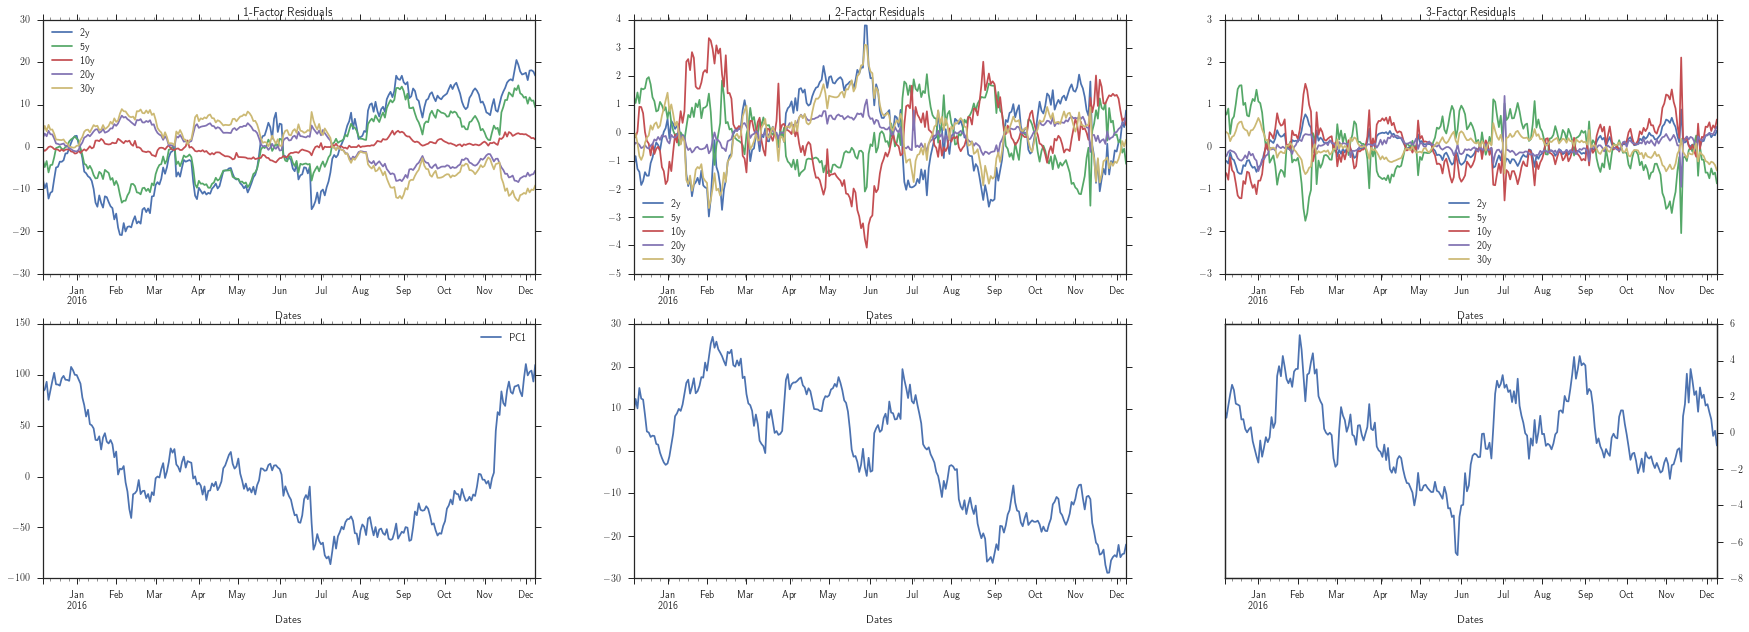

In [6]:
# Plot it.

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"]["PC2"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"]["PC3"].plot(ax=axes[1, 2], secondary_y="PC3")


From a cursory glane, it looks like duration is rich, the curve has flattened slightly and flies are cheap. We can verify this by plotting the principal components against rates, curve and fly.

                  PC1        PC2       PC3
Dates                                     
2015-12-08  83.996238   9.152955  1.331294
2015-12-09  85.655886  12.345938  0.841475
2015-12-10  93.367257  10.105458  1.507151
2015-12-11  75.602065  14.942333  2.131079
2015-12-14  84.978854  12.426146  2.663599


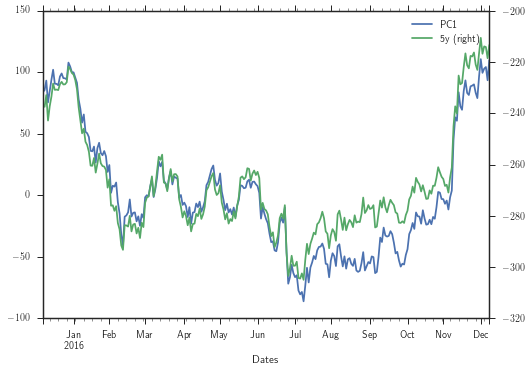

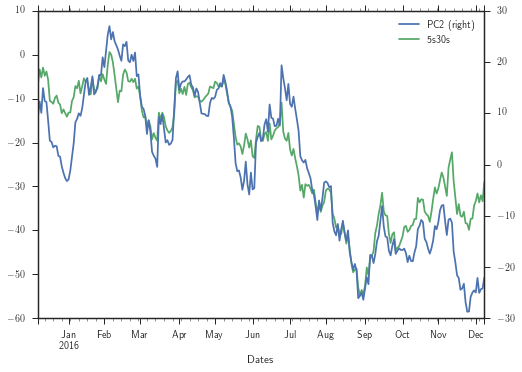

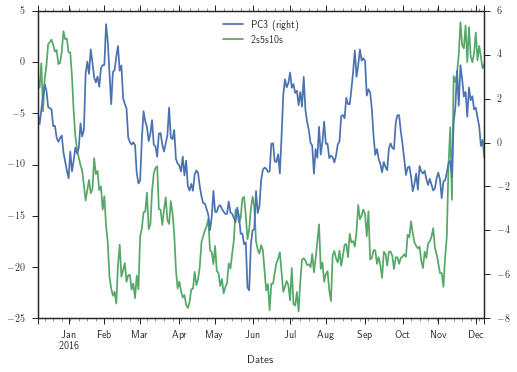

In [7]:


testpc1 = pd.DataFrame()
testpc1["PC1"] = pca3["facTS"]["PC1"].copy()
testpc1["5y"] = data["5y"]
testpc1.plot(secondary_y='5y')

testpc2 = pd.DataFrame()
testpc2["PC2"] = pca3["facTS"]["PC2"].copy()
testpc2["5s30s"] = data["30y"]-data["5y"]
testpc2.plot(secondary_y='PC2')

testpc3 = pd.DataFrame()
print (pca3["facTS"].head())
testpc3["PC3"] = pca3["facTS"]["PC3"].copy()
testpc3["2s5s10s"] = data["5y"]*2-data["2y"]-data["10y"]
testpc3.plot(secondary_y='PC3')

PC3 looks like it mean reverts quite well and is quite low historically. Thus, in looking at the PCA residuals, we will hope to find a fly or curve to receive.

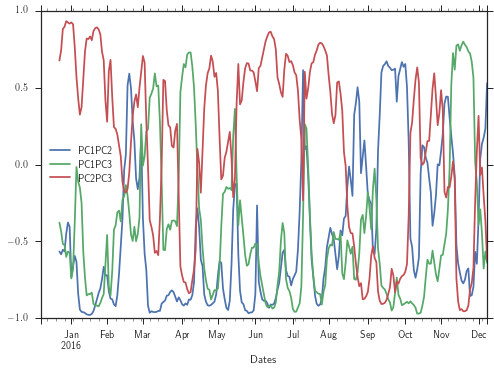

In [8]:
pca3["facCR"].plot()

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


            1d         1w         1m        3m
2y   16.839526  15.769571  10.079683  9.385040
5y    9.386926  10.189526   2.812727  5.420483
10y   1.721764   2.668580   1.992361  0.367942
20y  -5.641487  -6.126490  -3.893423 -3.304892
30y  -9.133014  -9.855341  -3.671315 -4.492774


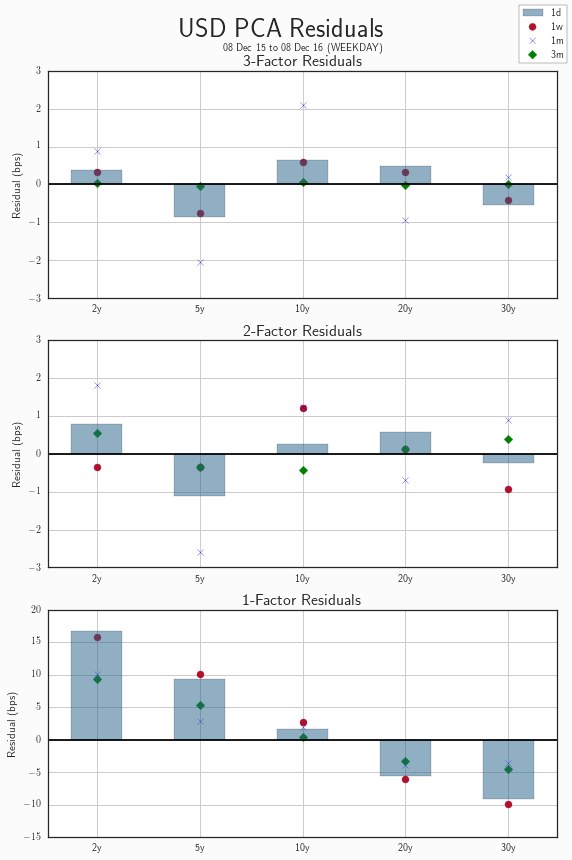

In [9]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()
print (relVal1)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 12), dpi=400, facecolor="#fbfbfb")
fig.suptitle("%s PCA Residuals"%currency, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
#ax1.set_axis_bgcolor('#f8fcff')
ax1.set_ylabel("Residual (bps)")

## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
#ax2.set_axis_bgcolor('#f8fcff')
ax2.set_ylabel("Residual (bps)")

## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
#ax3.set_axis_bgcolor('#f8fcff')
ax3.set_ylabel("Residual (bps)")

freq = firv.freqRules[pd.infer_freq(data.index)]
plt.text(0.5, 1.1,'%s to %s (%s)'%(firstDate, lastDate, freq), ha='center', va='center', transform=ax3.transAxes, fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], ["1d", "1w", "1m", "3m"], frameon=True,loc="upper right" )

plt.savefig("%s/depo/%s-PCA Residuals - %s %s"%(cwd, currency, lastDate, freq))

As expected, the two-factor residuals point to cheapening of the belly, and thus flies. Let's look at receiving 7s12s20s and 4s6s.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [10]:
def rollingPCA(data, lb=30, n=3, corrW=12, skip=1, autoOrient=2):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, corrW=corrW, autoOrient = autoOrient)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    ## Secret
    rollResult["master"] = alleVectors.dropna()
    
    return rollResult
            
#pcaResults = rollingPCA(rawData[:data.index.values[0]].dropna(), lb=252, skip=30, autoOrient=3)
pcaResults = rollingPCA(data, lb=30, autoOrient=2)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2016-12-02,99.1142,0.843826,0.0276062
2016-12-05,99.1224,0.833153,0.0295377
2016-12-06,99.1608,0.790268,0.0341814
2016-12-07,99.2295,0.711486,0.0442079
2016-12-08,99.2639,0.671174,0.0505376


####### PC1 historical ########
                  2y        5y       10y       20y       30y
2016-12-02  0.228377   0.48035  0.529788  0.480302  0.453587
2016-12-05  0.230943  0.482055  0.529628  0.479158  0.451874
2016-12-06   0.23629  0.485311  0.528635  0.476908  0.449159
2016-12-07  0.243297  0.489489  0.527376  0.474021  0.445406
2016-12-08  0.249317   0.49326  0.526256  0.471349  0.442064
####### PC2 historical ########
                  2y        5y        10y       20y       30y
2016-12-02 -0.588744 -0.524848 -0.0166298  0.339356  0.512324
2016-12-05   -0.5869 -0.523004 -0.0161038  0.340823   0.51536
2016-12-06   -0.5838 -0.516588 -0.0188139  0.341759  0.524558
2016-12-07  -0.57446  -0.50994 -0.0268213  0.345187  0.538594
2016-12-08 -0.563911 -0.503783 -0.0363213  0.346568  0.553876
####### PC3 historical ########
                  2y        5y       10y         20y       30y
2016-12-02 -0.763539  0.486956  0.206808 -0.00238573 -0.370278
2016-12-05 -0.766999  0.492783   0.20472

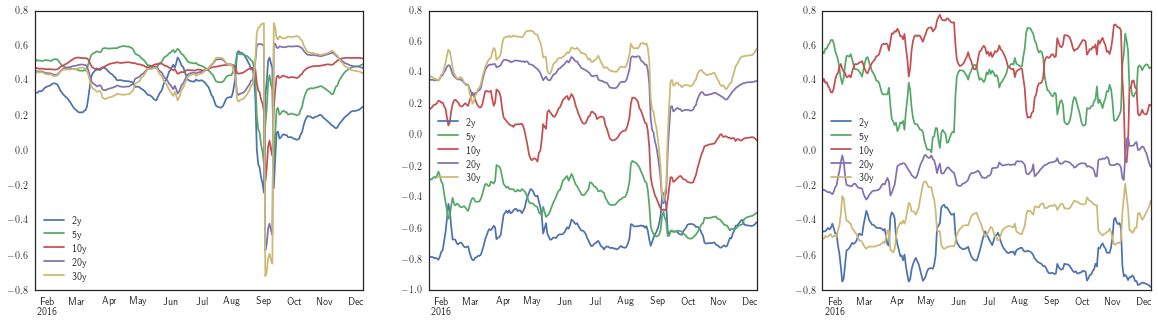

In [11]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

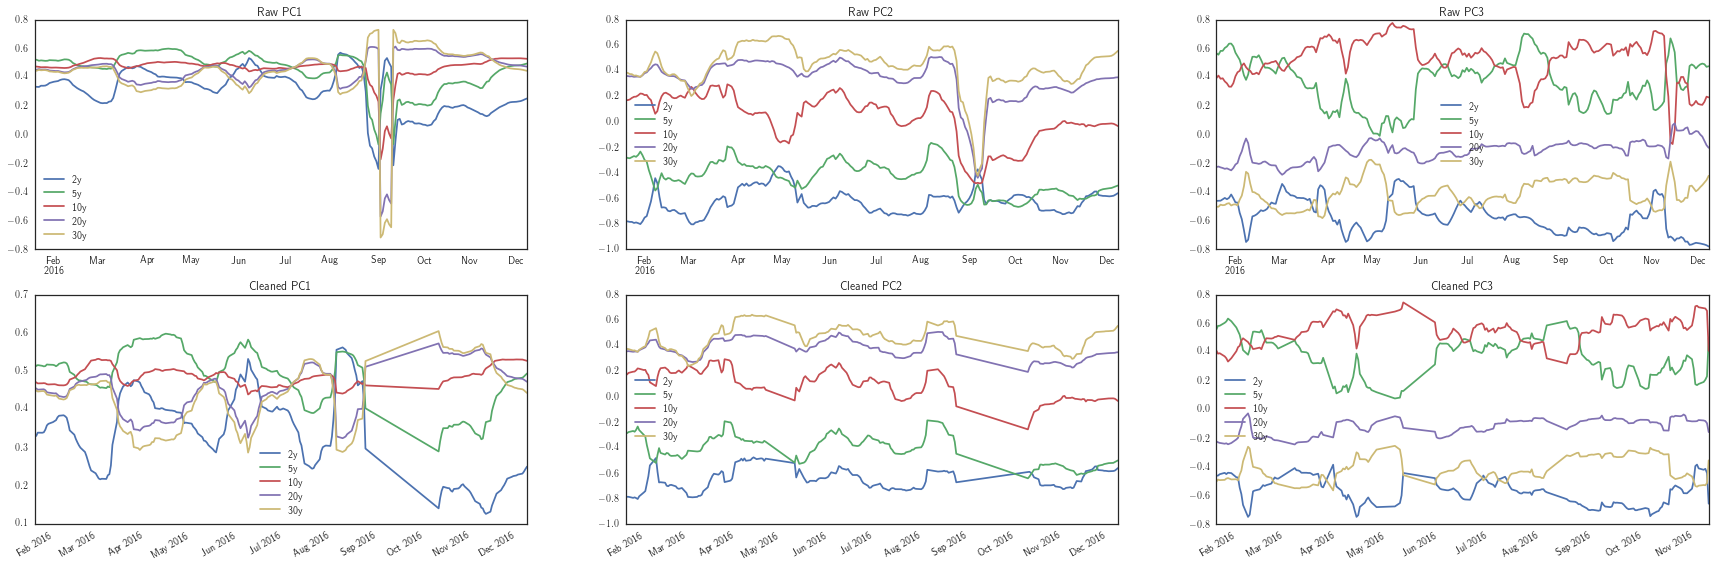

In [12]:

def cleanPCs(input, smoothing=1):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

A bit better...

What about the Eigenvalues?

               PC12y     PC15y    PC110y    PC120y    PC130y     PC22y  \
2016-01-19  0.331988  0.522499  0.473264  0.447389  0.438911 -0.787105   
2016-01-20  0.330423  0.518621  0.471626  0.450315  0.443439  -0.78542   
2016-01-21  0.329513   0.51267  0.469896  0.454022  0.449059 -0.789409   
2016-01-22  0.338217  0.515147   0.46719  0.450741  0.445869 -0.789573   
2016-01-25  0.337918  0.513233  0.467472  0.451655  0.447079  -0.79781   

               PC25y    PC210y    PC220y    PC230y     PC32y     PC35y  \
2016-01-19 -0.280381  0.170822  0.356618  0.381439 -0.466586  0.565503   
2016-01-20 -0.287219  0.166828  0.356441  0.381758 -0.465213  0.554635   
2016-01-21 -0.289433  0.172223  0.353424  0.372145 -0.464837  0.581228   
2016-01-22 -0.280687  0.184358  0.354993  0.371189  -0.45533   0.58167   
2016-01-25 -0.272287  0.193362  0.350187  0.359637 -0.445573  0.602103   

              PC310y    PC320y    PC330y  
2016-01-19  0.390642 -0.230175 -0.506875  
2016-01-20  0.409096 -0.

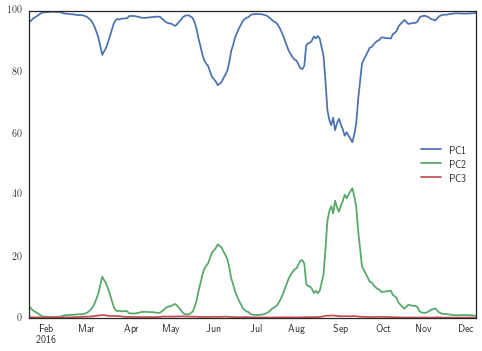

In [13]:
pcaResults["evalues"].plot()
print (pcaResults["master"].head())

Not too bad. 

# Snapshots over time

Alternatively, we can look at a snapshot of the eigenvectors and values at different points in time. This will hopefully provide a bit more insight than the previous rolling PCA charts which were quite noisy. This function will generate a subset of the rolling PCA results, showing only snapshots on an input set of dates and a lookback period on the rolling PCA.

In [14]:
"""
NEEED TO REWRITE 


lb = 250
lastDate = data.index.values[0]
lastIndex = list(rawData.index.values).index(lastDate)
testDates = [data.index.values[i] for i in range(lb, len(data.index.values), 250)]

target = pd.DataFrame(index=testDates)
print (testDates)

orig = pcaResults["master"]

result = target.join(orig)
#print (result)

def pcaSnapshot(dates, data, lb=30, n=3,orient=True, tol=1.5):
    # Returns tuple of evalues and a dict of evectors.
    reorient = len(dates)*[1]
    
    pcaResults = rollingPCA(data, lb=lb, n=n)
    orig = pcaResults["master"]
    evectors = pd.DataFrame(index=dates).join(orig)
    
    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])

    pcCols = evalues.columns.values
    
    grouped = evectors.groupby(lambda x: x[:3], axis=1)
    
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))
    flag = 0
    for pc in pcCols:
        if flag == 0 and orient :
            flag = 1
            temp = grouped.get_group(pc).dropna()
            temp['orient'] = temp.applymap(np.sign).sum(axis=1)
            reorient = temp["orient"].apply(lambda x: (-1)**((np.abs(x-temp["orient"].mean())/temp["orient"].std()<tol)-1))
        
        factors = grouped.get_group(pc).dropna()
            
        accumEvecs[pc] = factors.mul(reorient, axis=0)
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    
    return evalues, accumEvecs

testSnap = pcaSnapshot(testDates, rawData.dropna(), orient=True, tol=1.5)

print ("Done")

"""

'\nNEEED TO REWRITE \n\n\nlb = 250\nlastDate = data.index.values[0]\nlastIndex = list(rawData.index.values).index(lastDate)\ntestDates = [data.index.values[i] for i in range(lb, len(data.index.values), 250)]\n\ntarget = pd.DataFrame(index=testDates)\nprint (testDates)\n\norig = pcaResults["master"]\n\nresult = target.join(orig)\n#print (result)\n\ndef pcaSnapshot(dates, data, lb=30, n=3,orient=True, tol=1.5):\n    # Returns tuple of evalues and a dict of evectors.\n    reorient = len(dates)*[1]\n    \n    pcaResults = rollingPCA(data, lb=lb, n=n)\n    orig = pcaResults["master"]\n    evectors = pd.DataFrame(index=dates).join(orig)\n    \n    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])\n\n    pcCols = evalues.columns.values\n    \n    grouped = evectors.groupby(lambda x: x[:3], axis=1)\n    \n    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))\n    flag = 0\n    for pc in pcCols:\n        if flag == 0 and or

Let's display the results.

In [15]:
"""
NEED TO REWRITE
evalues = testSnap[0]
evectors = testSnap[1]

## Eigenvalues
display(evalues)
dateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]
ax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, dateStrings, loc="best")
ax.set_axis_bgcolor("#f8fcff")

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)


for i in range(len(evectors.keys())):
    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.set_axis_bgcolor('#f8fcff')
    ax.set_title("PC"+str(i+1))
    #ax.legend(lines, dateStrings, loc="best")

fig.suptitle("Eigenvectors over time", fontsize="26")
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.figlegend(lines, dateStrings, frameon=True,loc="upper right", ncol=len(dateStrings))

"""


'\nNEED TO REWRITE\nevalues = testSnap[0]\nevectors = testSnap[1]\n\n## Eigenvalues\ndisplay(evalues)\ndateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]\nax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)\nlines, labels = ax.get_legend_handles_labels()\nax.legend(lines, dateStrings, loc="best")\nax.set_axis_bgcolor("#f8fcff")\n\nfig, axes = plt.subplots(nrows=1, ncols=3)\nfig.set_size_inches(20, 5)\n\n\nfor i in range(len(evectors.keys())):\n    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)\n    lines, labels = ax.get_legend_handles_labels()\n    ax.set_axis_bgcolor(\'#f8fcff\')\n    ax.set_title("PC"+str(i+1))\n    #ax.legend(lines, dateStrings, loc="best")\n\nfig.suptitle("Eigenvectors over time", fontsize="26")\nfig.tight_layout()\nfig.subplots_adjust(top=0.8)\nplt.figlegend(lines, dateStrings, frameon=True,loc="upper righ

Not too bad.

# Generating weights for curve and fly trades

The next thing to do is create a function that would generated trades that are PC hedged. 

In [16]:
def getWgts(trade, evectors,bpvs=0):
    ### Returns risk to use in trades
    eVec = evectors.copy()
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
        eVec.index = newIndex

    if len(tenors)==2:
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-el/es, 1]
        
    
    if len(tenors)==3:
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(eVec).ix[:,:-1].transpose()
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(eVec).ix[:,:-1].transpose()
        invcoeff = np.linalg.pinv(wingFactors)
        bellyFactor.loc[:] *= -1
        rhs = invcoeff.dot(bellyFactor)
        rhs = [2*x for x in list(np.ravel(rhs))]
        rhs.insert(1, 2)
        
        return rhs
    else:
        print("Oops. Not enough, or too many instruments.")
    return

        

Testing it here:

In [17]:
#curve = "25y5y-30y10y"
fly = "2s5s10s"
#longfly = "12y3y-15y5y-20y5y"
curve = "10s20s"
#fly = "2s5s7s"
#longfly = "4s5s6s"
evectors = (pca3["evecs"])
#print (evectors)

pv01s = firv.pv01d
#print (getWgts(curve, pca3["evecs"]))
print (getWgts(fly, pca3["evecs"]))
print (getWgts(curve, pca3["evecs"]))

#print (getWgts(longfly, pca3["evecs"]))

[-1.1992267961258398, 2, -1.1951409915876829]
[-1.0205013846275719, 1]


We are going to need a function to generate the time series for weighted flies. 

83.8551915587
87.33350232432693
-7.21076569234
0.1877844533414413


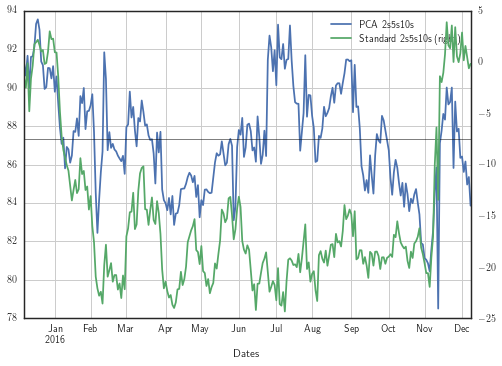

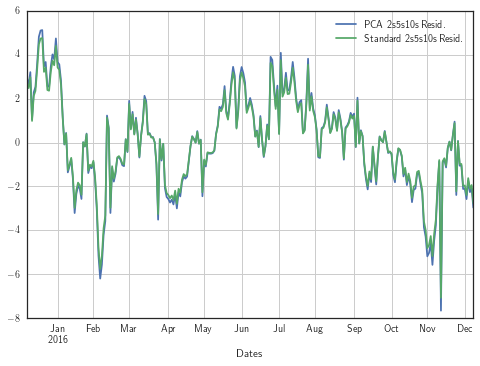

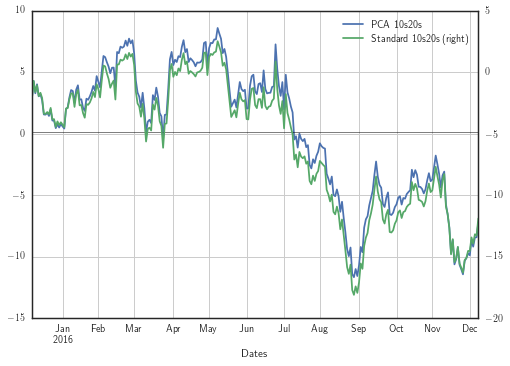

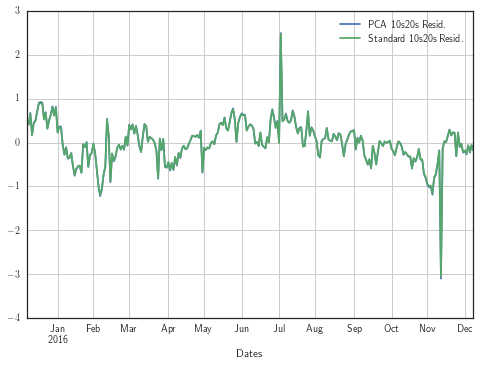

In [18]:
def genTrade(trade, data, pcaResult):
    eVec = pcaResult["evecs"].copy()
    
    
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in eVec.index.values]
        eVec.index = newIndex
        
    pcaWgts = getWgts(trade, eVec)
    
    result = data[tenors].copy()
    result["PCA "+trade] = result.dot(pcaWgts)
    
    if len(tenors) == 2:
        result["Standard "+trade] = result[tenors[1]] - result[tenors[0]]
    elif len(tenors)==3:
        legs = data[tenors].copy()
        result["Standard "+trade] = legs.dot(np.array([-1, 2, -1]))
    
    residuals = pcaResult["resid"][tenors].copy()
    residuals["PCA "+trade+" Resid."] = residuals.dot(pcaWgts)
    if len(tenors) == 2:
        residuals["Standard "+trade+" Resid."] = residuals[tenors[1]] - residuals[tenors[0]]
    elif len(tenors)==3:
        rlegs = residuals[tenors].copy()
        residuals["Standard "+trade+" Resid."] = rlegs.dot(np.array([-1, 2, -1]))    
    
    
    return result, residuals

#### 3s6s10s FLY #####
flyTrade, flyResiduals = genTrade(fly, data, pca3)
fmean = flyTrade["PCA "+fly].mean()
print (flyTrade["PCA "+fly][-1])
print (fmean)
ax1 = flyTrade.ix[:, 3:].plot(secondary_y="Standard "+fly, grid=True)
ax1.axhline(fmean, color="black", linewidth=0.5)
flyResiduals.ix[:, 3:].plot(grid=True)


### 15s20s CURVE ###
curveTrade, curveResiduals = genTrade(curve, data, pca3)
cmean = curveTrade["PCA "+curve].mean()
print (curveTrade["PCA "+curve][-1])
print (cmean)
ax2 = curveTrade.ix[:, 2:].plot(secondary_y="Standard "+curve, grid=True)
ax2.axhline(cmean, color="black", linewidth=0.5)
curveResiduals.ix[:, 2:].plot(grid=True)


The fly looks to mean revert quite well. We will test this a bit later.

It might be interesting to see what the PCA hedge really means visually by regressing vs. actual movements in the principal components. 

The residuals above point to receiving 2s5s10s. Let's model this trade. 

In [19]:
histFactors = pca3["facTS"]
residuals = pca3["resid"]
diffFactors = histFactors.diff()
#display(histFactors.tail())
#display(diffFactors.tail())
curves = curveTrade.ix[:, 2:]
curvesChg = curves.diff()
flies = flyTrade.ix[:, 3:]
fliesChg = flies.diff()
#display(curves.tail())
#display(curvesChg.tail())
#display(flies.tail())
#display(fliesChg.tail())

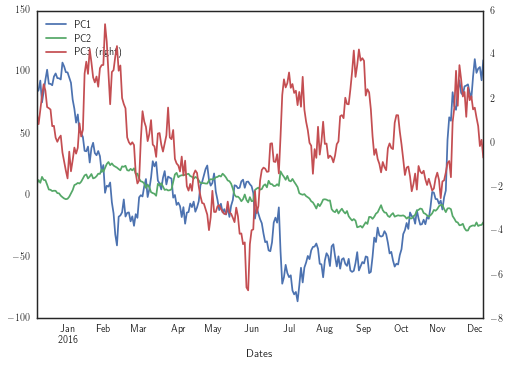

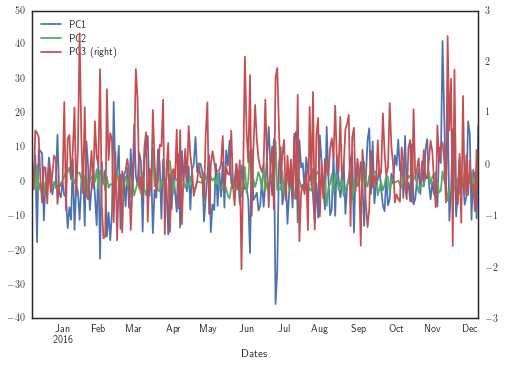

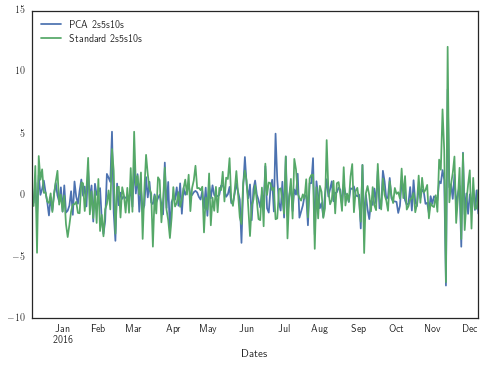

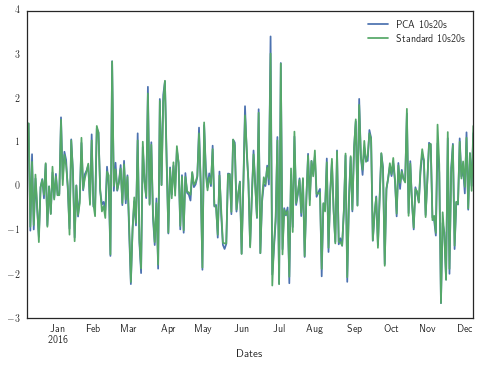

In [20]:
histFactors.plot(secondary_y="PC3")
diffFactors.plot(secondary_y="PC3")
fliesChg.plot()
curvesChg.plot()

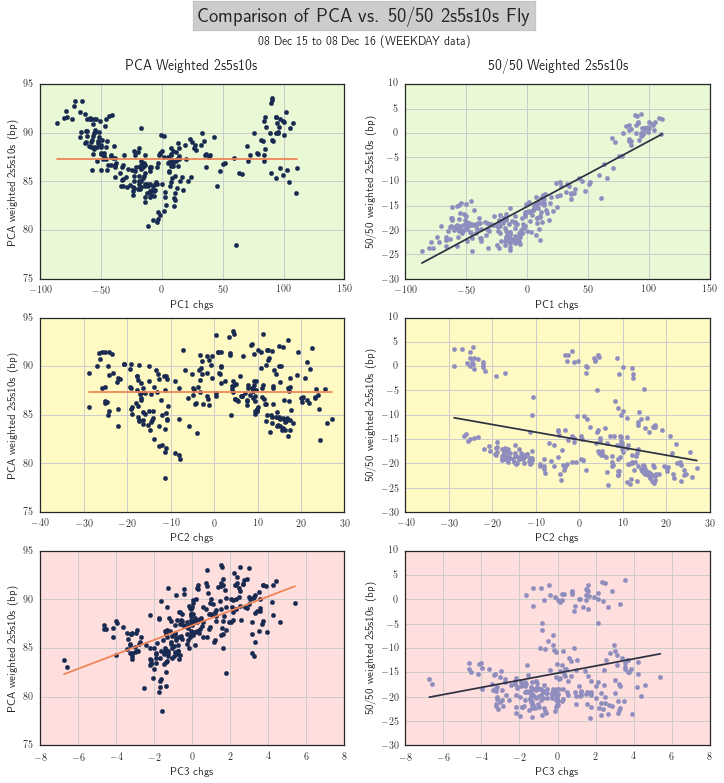

In [21]:
import statsmodels.api as sm
firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")
pcaFly = flyTrade["PCA "+fly].dropna().values
stdFly = flyTrade["Standard "+fly].dropna().values

across = ["PCA "+fly, "Std "+fly]

down = histFactors.index.values

trades = [pcaFly, stdFly]

colors = ["#ffdede", "#fffac4","#e9f9d6"][::-1]

def pcFlyRegress():
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(12,12)
    fig.suptitle("Comparison of PCA vs. 50/50 "+fly+" Fly", fontsize=20,bbox={'facecolor':'black', 'alpha':0.2, 'pad':5})
    fig.text(0.5, 0.94, "%s to %s (%s data)"%(firstDate, lastDate, freq),ha='center', va='center')
    
    fig.subplots_adjust(top=0.89)
    for i in range(len(axes)):
        x = histFactors["PC"+str(i+1)].dropna().values
        y = trades
        plot(axes[i], x, y, i)
    
    axes[0][1].set_title("50/50 Weighted "+fly, y=1.05, fontweight="bold",fontsize=14)
    axes[0][0].set_title("PCA Weighted "+fly, y=1.05, fontweight="bold", fontsize=14)

    plt.show()

def plot(axrow, x, y, i):
    axrow[0].scatter(x, y[0], color='#192A51', marker='o')
    axrow[0].grid()
    fit1 = np.polyfit(x, y[1], 1, full=True)
    axrow[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y[0], 1))(np.unique(x)), color="#EF8354")
    axrow[0].set_ylabel("PCA weighted "+fly+" (bp)")
    axrow[0].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[0].set_axis_bgcolor(colors[i])
    
    axrow[1].scatter(x, y[1], color='#8E8DBE')
    axrow[1].grid()
    fit2 = np.polyfit(x, y[1], 1, full=True)
    axrow[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y[1], 1))(np.unique(x)), color='#2D3142')
    axrow[1].set_ylabel("50/50 weighted "+fly+" (bp)")
    axrow[1].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[1].set_axis_bgcolor(colors[i])


pcFlyRegress()

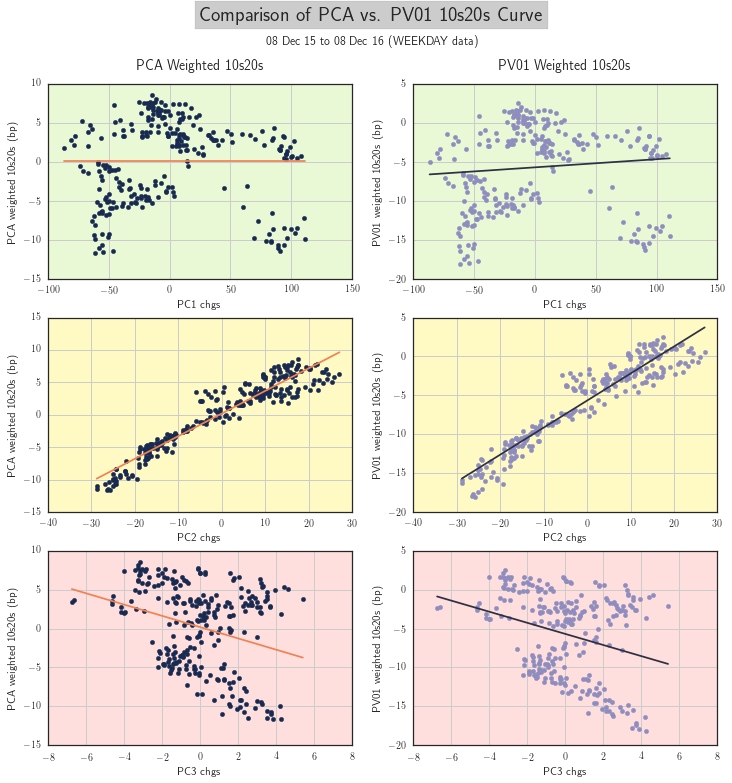

In [22]:
firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")
pcaCurve = curveTrade["PCA "+curve].dropna().values
stdCurve = curveTrade["Standard "+curve].dropna().values

across = ["PCA "+curve, "Std "+curve]

down = histFactors.index.values

trades = [pcaCurve, stdCurve]

colors = ["#ffdede", "#fffac4","#e9f9d6"][::-1]

def pcCurveRegress():
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(12,12)
    fig.suptitle("Comparison of PCA vs. PV01 "+curve+" Curve", fontsize=20,bbox={'facecolor':'black', 'alpha':0.2, 'pad':5})
    fig.text(0.5, 0.94, "%s to %s (%s data)"%(firstDate, lastDate, freq),ha='center', va='center')
    
    fig.subplots_adjust(top=0.89)
    for i in range(len(axes)):
        x = histFactors["PC"+str(i+1)].dropna().values
        y = trades
        plot(axes[i], x, y, i)
    
    axes[0][1].set_title("PV01 Weighted "+curve, y=1.05, fontweight="bold",fontsize=14)
    axes[0][0].set_title("PCA Weighted "+curve, y=1.05, fontweight="bold", fontsize=14)

    plt.show()

def plot(axrow, x, y, i):
    axrow[0].scatter(x, y[0], color='#192A51', marker='o')
    axrow[0].grid()
    fit1 = np.polyfit(x, y[1], 1, full=True)
    axrow[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y[0], 1))(np.unique(x)), color="#EF8354")
    axrow[0].set_ylabel("PCA weighted "+curve+" (bp)")
    axrow[0].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[0].set_axis_bgcolor(colors[i])
    
    axrow[1].scatter(x, y[1], color='#8E8DBE')
    axrow[1].grid()
    fit2 = np.polyfit(x, y[1], 1, full=True)
    axrow[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y[1], 1))(np.unique(x)), color='#2D3142')
    axrow[1].set_ylabel("PV01 weighted "+curve+" (bp)")
    axrow[1].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[1].set_axis_bgcolor(colors[i])

pcCurveRegress()

These charts are obvious as the PCA weights were fit to get this result. However, they are still a pretty visualization of what the PCA hedge really means. It is intended to be ignorant of the move in outright level and slope (PC1 and PC2), and a pure micro RV play on PC3.

If we were to put on the 50/50 fly to trade PC3, we would just be exposed to the outright level of rates and the curve with little exposure to the actual factor.

As for the curve, since the curve is not PC3 hedged, it has exposure to both the a change in steepeness and a change on convexity.

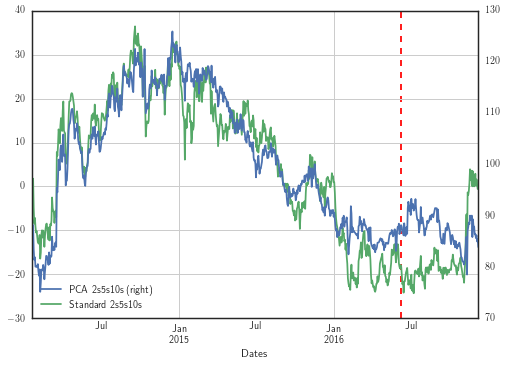

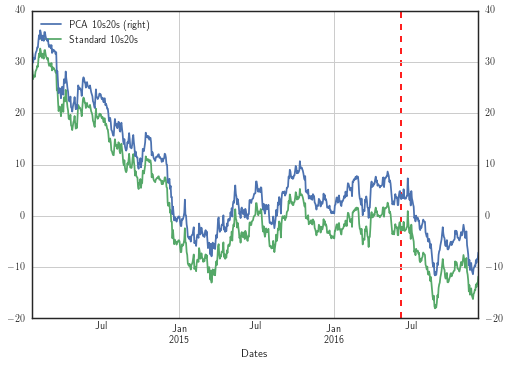

In [23]:
#curvePerf = genTrade(curve, rawData[end:dt.datetime(2016, 12, 30)], evectors)
flyPerf = genTrade(fly, rawData[dt.datetime(2014, 1, 20):dt.datetime(2017, 2, 8)], pca3)[0]
curvePerf = genTrade(curve, rawData[dt.datetime(2014, 1, 20):dt.datetime(2017, 2, 8)], pca3)[0]
end = dt.datetime(2016,6, 8)

ax1 = flyPerf.ix[:, 3:].plot(secondary_y="PCA "+fly) ## rec this
ax1.axvline(end, color='r', zorder=0, ls="dashed")
ax1.grid()

ax2 = curvePerf.ix[:, 2:].plot(secondary_y="PCA "+curve) ## rec this
ax2.axvline(end, color='r', zorder=0, ls="dashed")
ax2.grid()


Looks like these trades would've worked out. 

## Mean Reversion

The fly looks like it mean reverts quite well. Let's try using the ADF test.

In [24]:
import statsmodels.tsa.stattools as ts
print("Fly Residuals \n \t"+str(ts.adfuller(flyResiduals.ix[:,3], 1)))
print("Curve Residuals \n \t"+str(ts.adfuller(curveResiduals.ix[:,2], 1)))
print("Fly Trade\n \t"+str(ts.adfuller(flyTrade.ix[:,3], 1)))
print("Curve Trade \n \t"+str(ts.adfuller(curveTrade.ix[:,2], 1)))

Fly Residuals 
 	(-3.5094863449321294, 0.0077467808769438899, 1, 261, {'10%': -2.5727054883222502, '1%': -3.4556556713934934, '5%': -2.8726783524898591}, 817.94623198212093)
Curve Residuals 
 	(-5.0073093332796308, 2.1465675327488601e-05, 1, 261, {'10%': -2.5727054883222502, '1%': -3.4556556713934934, '5%': -2.8726783524898591}, 205.47993182441473)
Fly Trade
 	(-3.4030830656559168, 0.010854218049006006, 1, 261, {'10%': -2.5727054883222502, '1%': -3.4556556713934934, '5%': -2.8726783524898591}, 905.46005741200076)
Curve Trade 
 	(-1.176638664523721, 0.68356358423198227, 0, 262, {'10%': -2.5726826770001749, '1%': -3.4555581140287468, '5%': -2.8726355862774242}, 725.5730912583432)


Fly: Since the test statistic of -3.643 is smaller than the 1% critical value of -3.45, we can say that we are likely to have found a mean reverting series with 99% confidence. 

Curve: Since the test statistic of -2.01 is larger than the critical values, we cannot conclude that we have found a mean reverting series.

In [25]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(1,len(ts)-1)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print (hurst(pcaFly))
print (hurst(pcaCurve))

-0.028919625689
-0.0458718883362


Again, the Hurst exponent is very close to 0 indicating a good possibility of having found a mean reverting time series.

# Ornstein-Uhlenbeck parameter estimation (Fly)

Let's assume that the fly and curve follow a mean reverting OU process and estimate the model parameters using historical data. We will do another notebook on mean reversion that digs further into the time series later.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     733.7
Date:                Fri, 16 Dec 2016   Prob (F-statistic):           1.16e-77
Time:                        09:22:24   Log-Likelihood:                -458.08
No. Observations:                 262   AIC:                             920.2
Df Residuals:                     260   BIC:                             927.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         12.3280      2.770      4.451      0.0

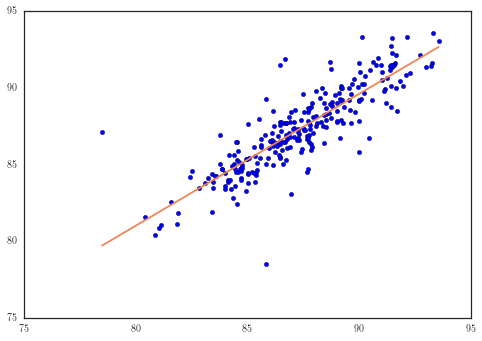

In [26]:
Si = pcaFly[:-1]
Sj = pcaFly[1:]


results = sm.OLS(Sj,sm.add_constant(Si)).fit()
print (results.summary())
print (results.params)
xmin, xmax = np.unique(Si).min(), np.unique(Si).max()
plt.scatter(Si, Sj)
X_plot = np.linspace(xmin,xmax,)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0],color="#EF8354")

plt.show()


Estimating OU model parameters:

In [27]:
a, b = results.params[1], results.params[0]
lamb = -np.log(a)
mu = b/(1-a)
sigma = np.sqrt(-2*np.log(a)/(1-a**2))

print ("lambda = "+str(lamb))
print ("Mu = "+str(mu))
print("Sigma = "+str(sigma))
print("Half life = "+str(np.log(2)/lamb))

lambda = 0.152524846321
Mu = 87.1470710251
Sigma = 1.07715711746
Half life = 4.54448699525


Comment for later: Half life looks really fast.... need to check.

In [28]:
ouModel = pd.DataFrame(index=flyPerf.index.values) 
ouModel = pd.concat([ouModel, flyTrade["PCA "+fly]], axis=1)
ouStart = flyTrade["PCA "+fly].index.values[-1]
ouStart = ouModel["PCA "+fly].last_valid_index()
stIdx = ouModel.index.get_loc(ouStart)
lastIdx = len(ouModel.index)-1
stVal = ouModel.ix[stIdx, 0]
print ("Last Value: "+str(stVal))
print (stIdx, lastIdx)
print (ouModel.ix[lastIdx, :])

Last Value: 83.8551915587
753 753
PCA 2s5s10s    83.855192
Name: 2016-12-08 00:00:00, dtype: float64


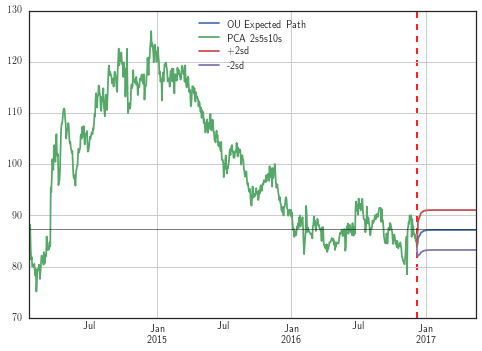

In [29]:
globalOU = []
##### NEED TO FIX THE RECURSIVE FUNCTION HERE... WORKS OK BUT NOT SCALABLE.
def ouGen(first,n, mu, lamb, sigma):
    a = np.exp(-lamb)
    b = mu*(1-np.exp(-lamb))
    if n == 0:
        globalOU.append(first)
        return [first]
    else:
        prev = a*ouGen(first, n-1, mu, lamb, sigma)[0]+b
        globalOU.append(prev)
        return [prev] + [a*prev + b]
      
def retOUexp(first, n, mu, lamb, sigma):
    
    ouresult = []
    
    ouGen(first, n, mu, lamb, sigma, ouresult)
    
    return ouresult
    
    
        
def ouConf(n, lamb, sigma, sd):
    sigmaSq = sigma**2
    ret = [sd*np.sqrt(sigmaSq/2/lamb*(1-np.exp(-2*lamb*i))) for i in range(n+1)]
    return ret

if (stIdx == lastIdx):
    n = 160
    ou2 = np.array(ouConf(n, lamb, sigma, 2))
    ouExp = ouGen(stVal, n, mu, lamb, sigma)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    ouDates = pd.date_range(ouStart, ouStart + dt.timedelta(days=n))
    pSigma = pd.DataFrame(p2sd, index=ouDates, columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouDates, columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouDates, columns=["OU Expected Path"])
    results = pd.concat([results, flyPerf["PCA "+fly], pSigma, nSigma], axis=1)

    
else:
    n = lastIdx - stIdx
    ou2 = np.array(ouConf(n, lamb, sigma, 2))
    ouExp = ouGen(stVal, n, mu, lamb, sigma)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    pSigma = pd.DataFrame(p2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouModel.index.values[stIdx:lastIdx+1], columns=["OU Expected Path"])
    results = pd.concat([results, flyPerf["PCA "+fly], pSigma, nSigma], axis=1)

mean = flyTrade["PCA "+fly].mean()
ax1 = results.plot()
ax1.axhline(mean, color="black", linewidth=0.5)
ax1.axvline(ouStart, color='r', zorder=0, ls="dashed")
ax1.grid()
